In [30]:
# Gradio app that takes seismic waveform as input and marks 2 phases on the waveform as output.

import gradio as gr
import numpy as np
import pandas as pd
from phasehunter.data_preparation import prepare_waveform
import torch
import io

from scipy.stats import gaussian_kde
from scipy.signal import resample
from bmi_topography import Topography
import earthpy.spatial as es

import obspy
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.header import FDSNNoDataException, FDSNTimeoutException, FDSNInternalServerException
from obspy.geodetics.base import locations2degrees
from obspy.taup import TauPyModel
from obspy.taup.helper_classes import SlownessModelError

from obspy.clients.fdsn.header import URL_MAPPINGS

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import ImageGrid

from glob import glob


def resample_waveform(waveform, original_freq, target_freq):
    """
    Resample a waveform from original frequency to target frequency using SciPy's resample function.
    
    Args:
    waveform (numpy.ndarray): The input waveform as a 1D array.
    original_freq (float): The original sampling frequency of the waveform.
    target_freq (float): The target sampling frequency of the waveform.
    
    Returns:
    resampled_waveform (numpy.ndarray): The resampled waveform as a 1D array.
    """
    # Calculate the resampling ratio
    resampling_ratio = target_freq / original_freq
    # Calculate the new length of the resampled waveform
    resampled_length = int(waveform.shape[-1] * resampling_ratio)
    # Resample the waveform using SciPy's resample function
    resampled_waveform = resample(waveform, resampled_length, axis=-1)
    
    return resampled_waveform

def make_prediction(waveform, sampling_rate):
    waveform = np.load(waveform)
    print('Loaded', waveform.shape)

    if len(waveform.shape) == 1:
        waveform = waveform.reshape(1, waveform.shape[0])
    print('Reshaped', waveform.shape)
    if sampling_rate != 100:
        waveform = resample_waveform(waveform, sampling_rate, 100)
        print('Resampled', waveform.shape)

    orig_waveform = waveform[:, :6000].copy()
    processed_input = prepare_waveform(waveform)

    # Make prediction
    with torch.inference_mode():
        output = model(processed_input)

    p_phase = output[:, 0]
    s_phase = output[:, 1]

    return processed_input, p_phase, s_phase, orig_waveform


def mark_phases(waveform, uploaded_file, p_thres, s_thres, sampling_rate):

    if uploaded_file is not None:
        waveform = uploaded_file.name

    processed_input, p_phase, s_phase, orig_waveform = make_prediction(waveform, sampling_rate)

    # Create a plot of the waveform with the phases marked
    if sum(processed_input[0][2] == 0): #if input is 1C
        fig, ax = plt.subplots(nrows=2, figsize=(10, 2), sharex=True)

        ax[0].plot(orig_waveform[0], color='black', lw=1)
        ax[0].set_ylabel('Norm. Ampl.')

    else: #if input is 3C
        fig, ax = plt.subplots(nrows=4, figsize=(10, 6), sharex=True)
        ax[0].plot(orig_waveform[0], color='black', lw=1)
        ax[1].plot(orig_waveform[1], color='black', lw=1)
        ax[2].plot(orig_waveform[2], color='black', lw=1)

        ax[0].set_ylabel('Z')
        ax[1].set_ylabel('N')
        ax[2].set_ylabel('E')


    do_we_have_p = (p_phase.std().item()*60 < p_thres)
    if do_we_have_p:
        p_phase_plot = p_phase*processed_input.shape[-1]
        p_kde = gaussian_kde(p_phase_plot)
        p_dist_space = np.linspace( min(p_phase_plot)-10, max(p_phase_plot)+10, 500 )
        ax[-1].plot( p_dist_space, p_kde(p_dist_space), color='r')
    else:
        ax[-1].text(0.5, 0.75, 'No P phase detected', horizontalalignment='center', verticalalignment='center', transform=ax[-1].transAxes)

    do_we_have_s = (s_phase.std().item()*60 < s_thres)
    if do_we_have_s:
        s_phase_plot = s_phase*processed_input.shape[-1]
        s_kde = gaussian_kde(s_phase_plot)
        s_dist_space = np.linspace( min(s_phase_plot)-10, max(s_phase_plot)+10, 500 )
        ax[-1].plot( s_dist_space, s_kde(s_dist_space), color='b')

        for a in ax:
            a.axvline(p_phase.mean()*processed_input.shape[-1], color='r', linestyle='--', label='P', alpha=do_we_have_p)
            a.axvline(s_phase.mean()*processed_input.shape[-1], color='b', linestyle='--', label='S', alpha=do_we_have_s)
    else:
        ax[-1].text(0.5, 0.25, 'No S phase detected', horizontalalignment='center', verticalalignment='center', transform=ax[-1].transAxes)

    ax[-1].set_xlabel('Time, samples')
    ax[-1].set_ylabel('Uncert., samples')
    ax[-1].legend()

    plt.subplots_adjust(hspace=0., wspace=0.)

    # Convert the plot to an image and return it
    fig.canvas.draw()
    image = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    return image

def bin_distances(distances, bin_size=10):
    # Bin the distances into groups of `bin_size` kilometers
    binned_distances = {}
    for i, distance in enumerate(distances):
        bin_index = distance // bin_size
        if bin_index not in binned_distances:
            binned_distances[bin_index] = (distance, i)
        elif i < binned_distances[bin_index][1]:
            binned_distances[bin_index] = (distance, i)

    # Select the first distance in each bin and its index
    first_distances = []
    for bin_index in binned_distances:
        first_distance, first_distance_index = binned_distances[bin_index]
        first_distances.append(first_distance_index)
    
    return first_distances

def variance_coefficient(residuals):
    # calculate the variance of the residuals
    var = residuals.var()
    # scale the variance to a coefficient between 0 and 1
    coeff = 1 - (var / (residuals.max() - residuals.min()))
    return coeff

def predict_on_section(client_name, timestamp, eq_lat, eq_lon, radius_km, source_depth_km, velocity_model, max_waveforms, conf_thres_P, conf_thres_S):
    distances, t0s, st_lats, st_lons, waveforms, names = [], [], [], [], [], []
    
    taup_model = TauPyModel(model=velocity_model)
    client = Client(client_name)

    window = radius_km / 111.2
    max_waveforms = int(max_waveforms)

    assert eq_lat - window > -90 and eq_lat + window < 90, "Latitude out of bounds"
    assert eq_lon - window > -180 and eq_lon + window < 180, "Longitude out of bounds"

    starttime = obspy.UTCDateTime(timestamp)
    endtime = starttime + 120

    try:
        print('Starting to download inventory')
        inv = client.get_stations(network="*", station="*", location="*", channel="*H*", 
                            starttime=starttime, endtime=endtime, 
                            minlatitude=(eq_lat-window), maxlatitude=(eq_lat+window),
                            minlongitude=(eq_lon-window), maxlongitude=(eq_lon+window), 
                            level='station')
        print('Finished downloading inventory')
        
    except (IndexError, FDSNNoDataException, FDSNTimeoutException, FDSNInternalServerException):
        fig, ax = plt.subplots()
        ax.text(0.5,0.5,'Something is wrong with the data provider, try another')
        fig.canvas.draw();
        image = np.array(fig.canvas.renderer.buffer_rgba())
        plt.close(fig)
        return image
    
    waveforms = []
    cached_waveforms = glob("data/cached/*.mseed")

    for network in inv:
        if network.code == 'SY':
            continue
        for station in network:
            print(f"Processing {network.code}.{station.code}...")
            distance = locations2degrees(eq_lat, eq_lon, station.latitude, station.longitude)

            arrivals = taup_model.get_travel_times(source_depth_in_km=source_depth_km, 
                                                    distance_in_degree=distance, 
                                                    phase_list=["P", "S"])

            if len(arrivals) > 0:

                starttime = obspy.UTCDateTime(timestamp) + arrivals[0].time - 15
                endtime = starttime + 60
                try:
                    filename=f'{network.code}_{station.code}_{starttime}'
                    if f"data/cached/{filename}.mseed" not in cached_waveforms:
                        print(f'Downloading waveform for {filename}')
                        waveform = client.get_waveforms(network=network.code, station=station.code, location="*", channel="*", 
                                                    starttime=starttime, endtime=endtime)
                        waveform.write(f"data/cached/{network.code}_{station.code}_{starttime}.mseed", format="MSEED")
                        print('Finished downloading and caching waveform')
                    else:
                        print('Reading cached waveform')
                        waveform = obspy.read(f"data/cached/{network.code}_{station.code}_{starttime}.mseed")
                        

                except (IndexError, FDSNNoDataException, FDSNTimeoutException, FDSNInternalServerException):
                    print(f'Skipping {network.code}_{station.code}_{starttime}')
                    continue
            
                waveform = waveform.select(channel="H[BH][ZNE]")
                waveform = waveform.merge(fill_value=0)
                waveform = waveform[:3].sort(keys=['channel'], reverse=True)

                len_check = [len(x.data) for x in waveform]
                if len(set(len_check)) > 1:
                    continue

                if len(waveform) == 3:
                    try:
                        waveform = prepare_waveform(np.stack([x.data for x in waveform]))

                        distances.append(distance)
                        t0s.append(starttime)
                        st_lats.append(station.latitude)
                        st_lons.append(station.longitude)
                        waveforms.append(waveform)
                        names.append(f"{network.code}.{station.code}")

                        print(f"Added {network.code}.{station.code} to the list of waveforms")

                    except:
                        continue
                
    
    # If there are no waveforms, return an empty plot
    if len(waveforms) == 0:
        print('No waveforms found')
        fig, ax = plt.subplots()
        ax.text(0.5,0.5,'No waveforms found')
        fig.canvas.draw();
        image = np.array(fig.canvas.renderer.buffer_rgba())
        plt.close(fig)
        output_picks = pd.DataFrame()
        output_picks.to_csv('data/picks.csv', index=False)
        output_csv = 'data/picks.csv'
        return image, output_picks, output_csv
    

    first_distances = bin_distances(distances, bin_size=10/111.2)

    # Edge case when there are way too many waveforms to process
    selection_indexes = np.random.choice(first_distances, 
                                         np.min([len(first_distances), max_waveforms]),
                                         replace=False)

    waveforms = np.array(waveforms)[selection_indexes]
    distances = np.array(distances)[selection_indexes]
    t0s = np.array(t0s)[selection_indexes]
    st_lats = np.array(st_lats)[selection_indexes]
    st_lons = np.array(st_lons)[selection_indexes]
    names = np.array(names)[selection_indexes]

    waveforms = [torch.tensor(waveform) for waveform in waveforms]

    print('Starting to run predictions')
    with torch.no_grad():
        waveforms_torch = torch.vstack(waveforms)
        output = model(waveforms_torch)

    p_phases = output[:, 0]
    s_phases = output[:, 1]

    p_phases = p_phases.reshape(len(waveforms),-1)
    s_phases = s_phases.reshape(len(waveforms),-1)

    # Max confidence - min variance    
    p_max_confidence = p_phases.std(axis=-1).min()
    s_max_confidence = s_phases.std(axis=-1).min()

    print(f"Starting plotting {len(waveforms)} waveforms")
    fig, ax = plt.subplots(ncols=3, figsize=(10, 3))
    
    # Plot topography
    print('Fetching topography')
    params = Topography.DEFAULT.copy()
    extra_window = 0.5
    params["south"] = np.min([st_lats.min(), eq_lat])-extra_window
    params["north"] = np.max([st_lats.max(), eq_lat])+extra_window
    params["west"] = np.min([st_lons.min(), eq_lon])-extra_window
    params["east"] = np.max([st_lons.max(), eq_lon])+extra_window

    topo_map = Topography(**params)
    topo_map.fetch()
    topo_map.load()

    print('Plotting topo')
    hillshade = es.hillshade(topo_map.da[0], altitude=10)
    
    topo_map.da.plot(ax = ax[1], cmap='Greys', add_colorbar=False, add_labels=False)
    topo_map.da.plot(ax = ax[2], cmap='Greys', add_colorbar=False, add_labels=False)
    ax[1].imshow(hillshade, cmap="Greys", alpha=0.5)

    output_picks = pd.DataFrame({'station_name' : [], 
                                'st_lat' : [], 'st_lon' : [],
                                 'starttime' : [], 
                                 'p_phase, s' : [], 'p_uncertainty, s' : [], 
                                 's_phase, s' : [], 's_uncertainty, s' : [],
                                 'velocity_p, km/s' : [], 'velocity_s, km/s' : []})
                        
    for i in range(len(waveforms)):
        print(f"Plotting waveform {i+1}/{len(waveforms)}")
        current_P = p_phases[i]
        current_S = s_phases[i]
        
        x = [t0s[i] + pd.Timedelta(seconds=k/100) for k in np.linspace(0,6000,6000)]
        x = mdates.date2num(x)

        # Normalize confidence for the plot
        p_conf = 1/(current_P.std()/p_max_confidence).item()
        s_conf = 1/(current_S.std()/s_max_confidence).item()

        delta_t = t0s[i].timestamp - obspy.UTCDateTime(timestamp).timestamp

        ax[0].plot(x, waveforms[i][0, 0]*10+distances[i]*111.2, color='black', alpha=0.5, lw=1)

        if (current_P.std().item()*60 < conf_thres_P) or (current_S.std().item()*60 < conf_thres_S):
            ax[0].scatter(x[int(current_P.mean()*waveforms[i][0].shape[-1])], waveforms[i][0, 0].mean()+distances[i]*111.2, color='r', alpha=p_conf, marker='|')
            ax[0].scatter(x[int(current_S.mean()*waveforms[i][0].shape[-1])], waveforms[i][0, 0].mean()+distances[i]*111.2, color='b', alpha=s_conf, marker='|')
        
            velocity_p = (distances[i]*111.2)/(delta_t+current_P.mean()*60).item()
            velocity_s = (distances[i]*111.2)/(delta_t+current_S.mean()*60).item()

            # Generate an array from st_lat to eq_lat and from st_lon to eq_lon
            x = np.linspace(st_lons[i], eq_lon, 50)
            y = np.linspace(st_lats[i], eq_lat, 50)
            
            # Plot the array
            ax[1].scatter(x, y, c=np.zeros_like(x)+velocity_p, alpha=0.1, vmin=0, vmax=8)
            ax[2].scatter(x, y, c=np.zeros_like(x)+velocity_s, alpha=0.1, vmin=0, vmax=8)

        else:
            velocity_p = np.nan
            velocity_s = np.nan
        
        ax[0].set_ylabel('Z')
        print(f"Station {st_lats[i]}, {st_lons[i]} has P velocity {velocity_p} and S velocity {velocity_s}")

        output_picks = output_picks.append(pd.DataFrame({'station_name': [names[i]], 
                                                        'st_lat' : [st_lats[i]], 'st_lon' : [st_lons[i]],
                                                        'starttime' : [str(t0s[i])], 
                                                        'p_phase, s' : [(delta_t+current_P.mean()*60).item()], 'p_uncertainty, s' : [current_P.std().item()*60], 
                                                        's_phase, s' : [(delta_t+current_S.mean()*60).item()], 's_uncertainty, s' : [current_S.std().item()*60],
                                                        'velocity_p, km/s' : [velocity_p], 'velocity_s, km/s' : [velocity_s]}))
        
        
    # Add legend
    ax[0].scatter(None, None, color='r', marker='|', label='P')
    ax[0].scatter(None, None, color='b', marker='|', label='S')
    ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax[0].xaxis.set_major_locator(mdates.SecondLocator(interval=20))
    ax[0].legend()

    print('Plotting stations')
    for i in range(1,3):
        ax[i].scatter(st_lons, st_lats, color='b', label='Stations')
        ax[i].scatter(eq_lon, eq_lat, color='r', marker='*', label='Earthquake')
        ax[i].set_aspect('equal')
        ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 50)

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)
    
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
    cbar = fig.colorbar(ax[2].scatter(None, None, c=velocity_p, alpha=0.5, vmin=0, vmax=8), cax=cb_ax)

    cbar.set_label('Velocity (km/s)')
    ax[1].set_title('P Velocity')
    ax[2].set_title('S Velocity')

    for a in ax:
        a.tick_params(axis='both', which='major', labelsize=8)
        
    plt.subplots_adjust(hspace=0., wspace=0.5)
    fig.canvas.draw();
    image = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)
    output_picks.to_csv(f'data/velocity/{eq_lat}_{eq_lon}_{timestamp}_{len(waveforms)}.csv', index=False)
    output_csv = f'data/velocity/{eq_lat}_{eq_lon}_{timestamp}_{len(waveforms)}.csv'

    return image, output_picks, output_csv

import numpy as np
from matplotlib import colors, cm

# Function to find the closest index for a given value in an array
def find_closest_index(array, value):
    return np.argmin(np.abs(array - value))

def compute_velocity_model(azimuth, elevation):
    filename = output_csv
    df = pd.read_csv(filename)

    # Current EQ location
    filename = filename.split("/")[-1]
    eq_lat = float(filename.split("_")[0])
    eq_lon = float(filename.split("_")[1])

    ## FIX THIS LATTER
    eq_depth = 10 ##FIX THIS LATTER
    ## FIX THIS LATTER

    # Define the region of interest (latitude, longitude, and depth ranges)
    lat_range = (np.min([df.st_lat.min(), eq_lat]), np.max([df.st_lat.max(), eq_lat]))
    lon_range = (np.min([df.st_lon.min(), eq_lon]),  np.max([df.st_lon.max(), eq_lon]))
    depth_range = (0, 50)

    # Define the number of nodes in each dimension
    n_lat = 10
    n_lon = 10
    n_depth = 10
    num_points = 100

    # Create the grid
    lat_values = np.linspace(lat_range[0], lat_range[1], n_lat)
    lon_values = np.linspace(lon_range[0], lon_range[1], n_lon)
    depth_values = np.linspace(depth_range[0], depth_range[1], n_depth)

    # Initialize the velocity model with constant values
    initial_velocity = 0  # km/s, this can be P-wave or S-wave velocity
    velocity_model = np.full((n_lat, n_lon, n_depth), initial_velocity, dtype=float)

    # Loop through the stations and update the velocity model
    for i in range(len(df)):
        if ~np.isnan(df['velocity_p, km/s'].iloc[i]):
            # Interpolate coordinates along the great circle path between the earthquake and the station
            lon_deg = np.linspace(df.st_lon.iloc[i], eq_lon, num_points)
            lat_deg = np.linspace(df.st_lat.iloc[i], eq_lat, num_points)
            depth_interpolated = np.interp(np.linspace(0, 1, num_points), [0, 1], [eq_depth, 0])

            # Loop through the interpolated coordinates and update the grid cells with the average P-wave velocity
            for lat, lon, depth in zip(lat_deg, lon_deg, depth_interpolated):
                lat_index = find_closest_index(lat_values, lat)
                lon_index = find_closest_index(lon_values, lon)
                depth_index = find_closest_index(depth_values, depth)
                
                if velocity_model[lat_index, lon_index, depth_index] == initial_velocity:
                    velocity_model[lat_index, lon_index, depth_index] = df['velocity_p, km/s'].iloc[i]
                else:
                    velocity_model[lat_index, lon_index, depth_index] = (velocity_model[lat_index, lon_index, depth_index] +
                                                                        df['velocity_p, km/s'].iloc[i]) / 2
                    
    # Create the figure and axis
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Set the plot limits
    ax.set_xlim3d(lat_range[0], lat_range[1])
    ax.set_ylim3d(lon_range[0], lon_range[1])
    ax.set_zlim3d(depth_range[1], depth_range[0])

    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.set_zlabel('Depth (km)')
    ax.set_title('Velocity Model')
    
    # Create the meshgrid
    x, y, z = np.meshgrid(
        np.linspace(lat_range[0], lat_range[1], velocity_model.shape[0]+1),
        np.linspace(lon_range[0], lon_range[1], velocity_model.shape[1]+1),
        np.linspace(depth_range[0], depth_range[1], velocity_model.shape[2]+1),
        indexing='ij'
    )

    # Create the color array
    norm = plt.Normalize(vmin=velocity_model.min(), vmax=velocity_model.max())
    colors = plt.cm.plasma(norm(velocity_model))

    # Plot the voxels
    ax.voxels(x, y, z, velocity_model > 0, facecolors=colors, alpha=0.5, edgecolor='k')

    # Set the view angle
    ax.view_init(elev=elevation, azim=azimuth)

    m = cm.ScalarMappable(cmap=plt.cm.plasma, norm=norm)
    m.set_array([])
    plt.colorbar(m)

    # Show the plot
    fig.canvas.draw();
    image = np.array(fig.canvas.renderer.buffer_rgba())
    plt.close(fig)

    return image

model = torch.jit.load("model.pt")

with gr.Blocks() as demo:
    gr.HTML("""
<div style="padding: 20px; border-radius: 10px;">
    <h1 style="font-size: 30px; text-align: center; margin-bottom: 20px;">PhaseHunter <span style="animation: arrow-anim 10s linear infinite; display: inline-block; transform: rotate(45deg) translateX(-20px);">🏹</span>

<style>
    @keyframes arrow-anim {
        0% { transform: translateX(-20px); }
        50% { transform: translateX(20px); }
        100% { transform: translateX(-20px); }
    }
</style></h1> 
    
    <p style="font-size: 16px; margin-bottom: 20px;">Detect <span style="background-image: linear-gradient(to right, #ED213A, #93291E); 
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    background-clip: text;">P</span> and <span style="background-image: linear-gradient(to right, #00B4DB, #0083B0); 
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    background-clip: text;">S</span> seismic phases with <span style="background-image: linear-gradient(to right, #f12711, #f5af19); 
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    background-clip: text;">uncertainty</span></p>
    <ul style="font-size: 16px; margin-bottom: 40px;">
        <li>Detect seismic phases by selecting a sample waveform or uploading your own waveform in <code>.npy</code> format.</li>
        <li>Select an earthquake from the global earthquake catalogue and PhaseHunter will analyze seismic stations in the given radius.</li>
        <li>Waveforms should be sampled at 100 samples/sec and have 3 (Z, N, E) or 1 (Z) channels. PhaseHunter analyzes the first 6000 samples of your file.</li>
    </ul>
</div>
""")
        
    with gr.Tab("Select earthquake from catalogue"):

        gr.HTML("""
        <div style="padding: 20px; border-radius: 10px; font-size: 16px;">
        <p style="font-weight: bold; font-size: 24px; margin-bottom: 20px;">Using PhaseHunter to Analyze Seismic Waveforms</p>
        <p>Select an earthquake from the global earthquake catalogue (e.g. <a href="https://earthquake.usgs.gov/earthquakes/map">USGS</a>) and the app will download the waveform from the FDSN client of your choice. The app will use a velocity model of your choice to select appropriate time windows for each station within a specified radius of the earthquake.</p>
        <p>The app will then analyze the waveforms and mark the detected phases on the waveform. Pick data for each waveform is reported in seconds from the start of the waveform.</p>
        <p>Velocities are derived from distance and travel time determined by PhaseHunter picks (<span style="font-style: italic;">v = distance/predicted_pick_time</span>). The background of the velocity plot is colored by DEM.</p>
        </div>
        """)
        with gr.Row(): 
            with gr.Column(scale=2):
                client_inputs = gr.Dropdown(
                    choices = list(URL_MAPPINGS.keys()), 
                    label="FDSN Client", 
                    info="Select one of the available FDSN clients",
                    value = "IRIS",
                    interactive=True
                )

                velocity_inputs = gr.Dropdown(
                    choices = ['1066a', '1066b', 'ak135', 
                            'ak135f', 'herrin', 'iasp91', 
                            'jb', 'prem', 'pwdk'], 
                    label="1D velocity model", 
                    info="Velocity model for station selection",
                    value = "1066a",
                    interactive=True
                )

            with gr.Column(scale=2):
                timestamp_inputs = gr.Textbox(value='2019-07-04 17:33:49',
                                    placeholder='YYYY-MM-DD HH:MM:SS',
                                    label="Timestamp",
                                    info="Timestamp of the earthquake",
                                    max_lines=1,
                                    interactive=True)
                
                source_depth_inputs = gr.Number(value=10,
                    label="Source depth (km)",
                    info="Depth of the earthquake",
                    interactive=True)
                
            with gr.Column(scale=2):
                eq_lat_inputs = gr.Number(value=35.766, 
                                label="Latitude", 
                                info="Latitude of the earthquake",
                                interactive=True)
                
                eq_lon_inputs = gr.Number(value=-117.605,
                                    label="Longitude",
                                    info="Longitude of the earthquake",
                                    interactive=True)
                
            with gr.Column(scale=2):
                radius_inputs = gr.Slider(minimum=1, 
                                        maximum=200, 
                                        value=50, 
                                        label="Radius (km)", 
                                        step=10,
                                        info="""Select the radius around the earthquake to download data from.\n 
                                        Note that the larger the radius, the longer the app will take to run.""",
                                        interactive=True)
                
                max_waveforms_inputs = gr.Slider(minimum=1,
                                maximum=100,
                                value=10,
                                label="Max waveforms per section",
                                step=1,
                                info="Maximum number of waveforms to show per section\n (to avoid long prediction times)",
                                interactive=True,
                                )
            with gr.Column(scale=2):
                P_thres_inputs = gr.Slider(minimum=0.01,
                                maximum=1,
                                value=0.1,
                                label="P uncertainty threshold, s",
                                step=0.01,
                                info="Acceptable uncertainty for P picks expressed in std() seconds",
                                interactive=True,
                                )
                S_thres_inputs = gr.Slider(minimum=0.01,
                                maximum=1,
                                value=0.2,
                                label="S uncertainty threshold, s",
                                step=0.01,
                                info="Acceptable uncertainty for S picks expressed in std() seconds",
                                interactive=True,
                                )
            
        button = gr.Button("Predict phases")
        output_image = gr.Image(label='Waveforms with Phases Marked', type='numpy', interactive=False)

        with gr.Row():
            output_picks = gr.Dataframe(label='Pick data', 
                                        type='pandas', 
                                        interactive=False)
            output_csv = gr.File(label="Output File", file_types=[".csv"])

        button.click(predict_on_section, 
                 inputs=[client_inputs, timestamp_inputs, 
                         eq_lat_inputs, eq_lon_inputs, 
                         radius_inputs, source_depth_inputs, 
                         velocity_inputs, max_waveforms_inputs,
                         P_thres_inputs, S_thres_inputs],
                 outputs=[output_image, output_picks, output_csv])
        
        with gr.Row():
            with gr.Column(scale=2):
                inputs_vel_model = [
                    ## FIX FILE NAME ISSUE
                    gr.Slider(minimum=-180, maximum=180, value=0, step=5, label="Azimuth", interactive=True),
                    gr.Slider(minimum=-90, maximum=90, value=30, step=5, label="Elevation", interactive=True)
                ]
                button = gr.Button("Look at 3D Velocities")
            outputs_vel_model = gr.Image(label="3D Velocity Model")

            button.click(compute_velocity_model, 
                         inputs=inputs_vel_model, 
                         outputs=outputs_vel_model)

    with gr.Tab("Try on a single station"):
        with gr.Row(): 
            # Define the input and output types for Gradio
            inputs = gr.Dropdown(
                ["data/sample/sample_0.npy", 
                "data/sample/sample_1.npy", 
                "data/sample/sample_2.npy"], 
                label="Sample waveform", 
                info="Select one of the samples",
                value = "data/sample/sample_0.npy"
            )
            with gr.Column(scale=1):
                P_thres_inputs = gr.Slider(minimum=0.01,
                                    maximum=1,
                                    value=0.1,
                                    label="P uncertainty threshold, s",
                                    step=0.01,
                                    info="Acceptable uncertainty for P picks expressed in std() seconds",
                                    interactive=True,
                                    )
                
                S_thres_inputs = gr.Slider(minimum=0.01,
                                    maximum=1,
                                    value=0.2,
                                    label="S uncertainty threshold, s",
                                    step=0.01,
                                    info="Acceptable uncertainty for S picks expressed in std() seconds",
                                    interactive=True,
                                    )
            with gr.Column(scale=1):
                upload = gr.File(label="Or upload your own waveform")
                sampling_rate_inputs = gr.Slider(minimum=10,
                        maximum=1000,
                        value=100,
                        label="Samlping rate, Hz",
                        step=10,
                        info="Sampling rate of the waveform",
                        interactive=True,
                        )

        button = gr.Button("Predict phases")
        outputs = gr.Image(label='Waveform with Phases Marked', type='numpy', interactive=False)
    
        button.click(mark_phases, inputs=[inputs, upload, 
                                          P_thres_inputs, S_thres_inputs,
                                          sampling_rate_inputs], 
                                          outputs=outputs)

            


demo.launch()

Running on local URL:  http://127.0.0.1:7876

To create a public link, set `share=True` in `launch()`.


Loaded (6000,)
Reshaped (1, 6000)
Resampled (1, 3000)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


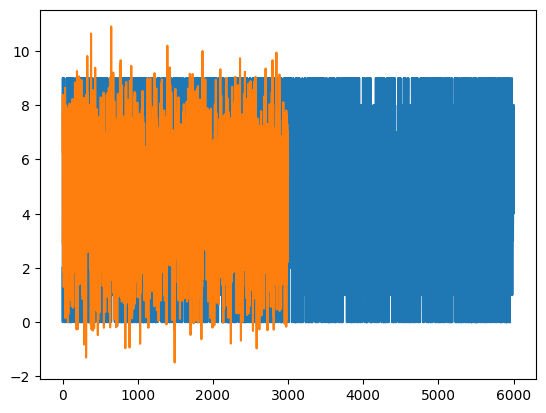

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/site-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/site-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/site-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/site-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/site-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "/var/folders/ky/4j6xbvhs5m583jflkhyzxf9h0000gn/T/ipykernel_9385/3876498698.py", line 76, in mark_phases
    waveform = resam

In [24]:
a = np.load("test.npy")    
plt.plot(a)

b  =  resample_waveform(a, 200, 100)
plt.plot(b)

In [6]:
np.save("test.npy", np.random.randint(0,10, size=(6000)))

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import gradio as gr
    
# Define the Gradio interface



Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


/var/folders/ky/4j6xbvhs5m583jflkhyzxf9h0000gn/T/ipykernel_19576/4006067033.py:95: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(m)



KeyboardInterrupt



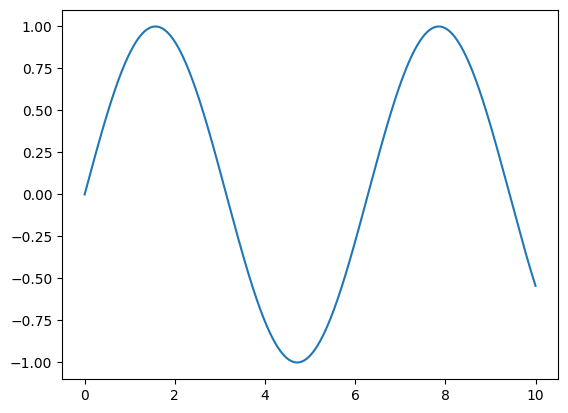

In [20]:
# generate sin of shape (1,5000)
x = np.linspace(0, 10, 5000)
y = np.sin(x)

y_resampled = resample_waveform(y, 1000, 100)
# plot sin
plt.plot(x, y)
plt.plot(x, y_resampled)